# Table of Contents
 <p><div class="lev1"><a href="#Data-preparation"><span class="toc-item-num">1 - </span>Data preparation</a></div><div class="lev1"><a href="#Data-pipeline"><span class="toc-item-num">2 - </span>Data pipeline</a></div><div class="lev2"><a href="#Selecting-appliances"><span class="toc-item-num">2.1 - </span>Selecting appliances</a></div><div class="lev2"><a href="#Selecting-time-sequences"><span class="toc-item-num">2.2 - </span>Selecting time sequences</a></div><div class="lev2"><a href="#Selecting-houses"><span class="toc-item-num">2.3 - </span>Selecting houses</a></div><div class="lev2"><a href="#Dealing-with-unbalanced-data:-selecting-aggregated-data-windows"><span class="toc-item-num">2.4 - </span>Dealing with unbalanced data: selecting aggregated data windows</a></div><div class="lev2"><a href="#Synthetic-aggregated-data"><span class="toc-item-num">2.5 - </span>Synthetic aggregated data</a></div><div class="lev1"><a href="#Standardisation-of-the-input-data-(aggregated-data)"><span class="toc-item-num">3 - </span>Standardisation of the input data (aggregated data)</a></div><div class="lev1"><a href="#Output-data-(start-time,-end-time-and-average-power)"><span class="toc-item-num">4 - </span>Output data (start time, end time and average power)</a></div><div class="lev1"><a href="#Scores---performance-evaluation-of-the-neural-network"><span class="toc-item-num">5 - </span>Scores - performance evaluation of the neural network</a></div><div class="lev1"><a href="#Implementation-strategy-for-real-time-data-augmentation"><span class="toc-item-num">6 - </span>Implementation strategy for real time data augmentation</a></div><div class="lev1"><a href="#Network-architecture"><span class="toc-item-num">7 - </span>Network architecture</a></div><div class="lev1"><a href="#Loss-function-and-optimizer"><span class="toc-item-num">8 - </span>Loss function and optimizer</a></div><div class="lev2"><a href="#Loss-function"><span class="toc-item-num">8.1 - </span>Loss function</a></div><div class="lev2"><a href="#Optimizer"><span class="toc-item-num">8.2 - </span>Optimizer</a></div><div class="lev1"><a href="#Experimenting-with-ConvNet-architectures"><span class="toc-item-num">9 - </span>Experimenting with ConvNet architectures</a></div><div class="lev2"><a href="#One-convolutional-layer"><span class="toc-item-num">9.1 - </span>One convolutional layer</a></div><div class="lev1"><a href="#Two-convolutional-layers"><span class="toc-item-num">10 - </span>Two convolutional layers</a></div><div class="lev2"><a href="#Results-for-the-microwave"><span class="toc-item-num">10.1 - </span>Results for the microwave</a></div>

This notebook is the report on the convolutional neural network implementation applied to energy disaggregation. All the codes are in the repository: https://github.com/tperol/neuralnilm. We did not transfer all the codes to this final repository in order to keep this clean. The data can also be found in https://github.com/tperol/neuralnilm. Some of the codes (mostly preprocessing of the data, although it was done for an other dataset) has been forked from Jack Kelly github Repository Neuralnilm (https://github.com/JackKelly/neuralnilm). We have implemented here all the neural network architectures tested as well as the preprocessing and the score metrics. The data preprocessing has been slightly edited from Jack Kelly's code to be fed to the Neural Network through a python generator that does the data augmentation on CPU while the GPU is training the network (see details later).

In [19]:
# for plotting purposes
%matplotlib inline
from matplotlib.pylab import plt
from matplotlib import rcParams

dark_colors = ["#A51C30", "#808080",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]
# dark_colors = ['#A51C30', '#808080']
rcParams['figure.figsize'] = (13, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="gray"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 0.3
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

# Data preparation

We have power data for 6 houses from main meters that measure the aggregate power consumption of the house and from each appliance separately. For example here we show the aggregated data (sum of all appliances in the house) for house 2.

Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


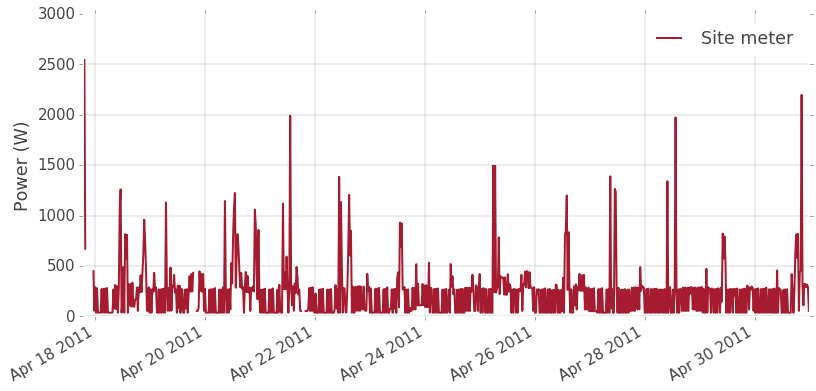

In [20]:
from __future__ import print_function
import nilmtk
from nilmtk.utils import print_dict
from nilmtk import DataSet

# import dataset
dataset = DataSet('./redd_data/redd.h5')
dataset.set_window("2011-04-01", "2011-05-01")
# look at house 2
BUILDING = 2
elec = dataset.buildings[BUILDING].elec
# plot mains
elec.mains().plot(kind = 'sum');

One contribution to this aggregated data is the cycles of the fridge plotted below.

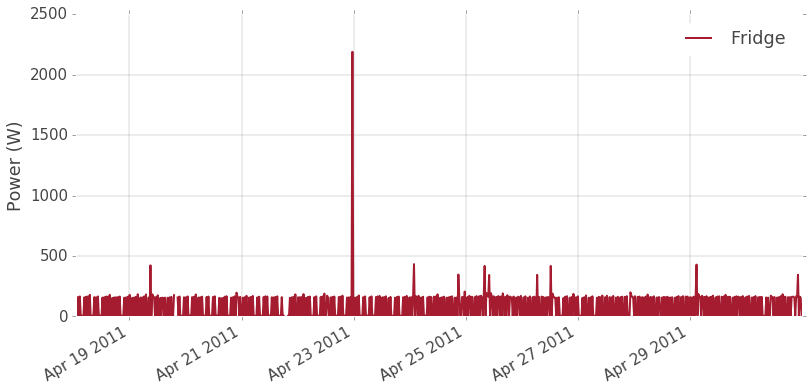

In [21]:
elec['fridge'].plot();

Of course there are many other appliances that contributes to the aggregated data observed above. The list of appliances listed in this house is shown here:

In [34]:
elec.submeters().appliances

[Appliance(type='fridge', instance=1),
 Appliance(type='washer dryer', instance=1),
 Appliance(type='dish washer', instance=1),
 Appliance(type='light', instance=1),
 Appliance(type='electric stove', instance=1),
 Appliance(type='sockets', instance=1),
 Appliance(type='microwave', instance=1),
 Appliance(type='sockets', instance=2),
 Appliance(type='waste disposal unit', instance=1)]

The sum of all these appliances is highly correlated to the aggregated data.

In [35]:
corr = elec.correlation_of_sum_of_submeters_with_mains()
print
print('------------------------------------------------------------------------------')
print('the correlation between the sum of the submeters and the main meter is:', corr)
print('------------------------------------------------------------------------------')

Running MeterGroup.correlation_of_sum_of_submeters_with_mains...
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=10, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
------------------------------------------------------------------------------
the correlation between the sum of the submeters and the main meter is: 0.84646056815
-----------------

We can visualize this looking at the main meters for one day and the sum of all the appliances for one day.

Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


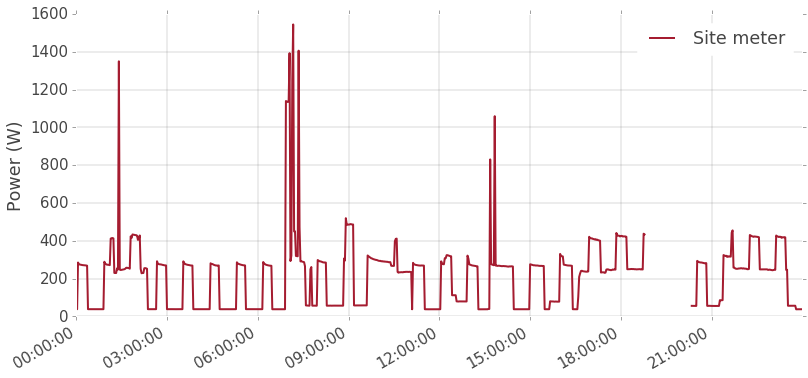

In [22]:
dataset = DataSet('./redd_data/redd.h5')
dataset.set_window("2011-04-19", "2011-04-20")
dataset.buildings[2].elec.mains().plot(kind= 'sum');

Loading data for meter ElecMeterID(instance=11, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


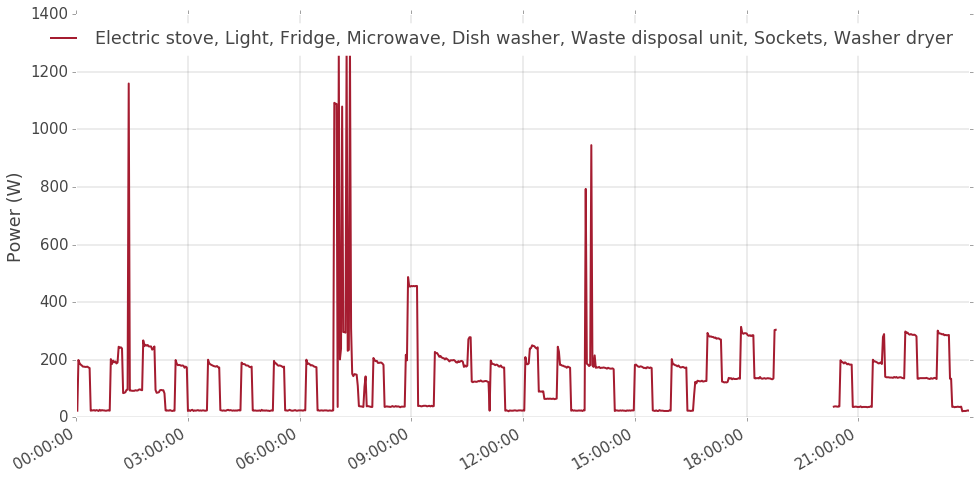

In [24]:
plt.figure(figsize = (16,8))
dataset.buildings[2].elec.submeters().plot(kind = 'sum');

The correlation is high because the 9 appliances listed above consume a significant proportion of the energy and represent a range of different power 'signatures'. Here is one signature from the fridge and one signature from the microwave.

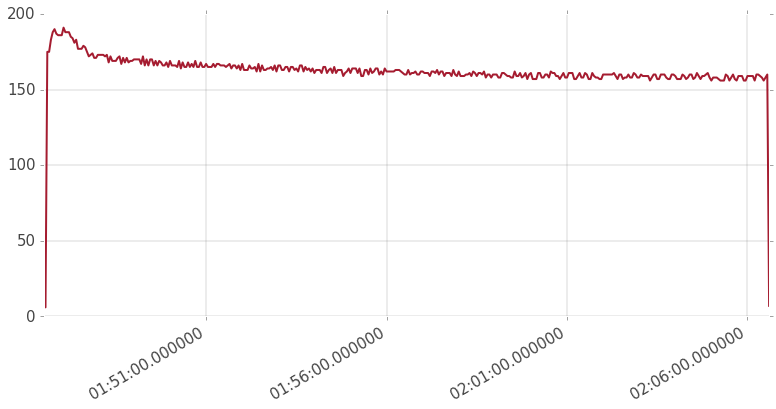

In [25]:
elec['fridge'].get_activations()[0].plot();

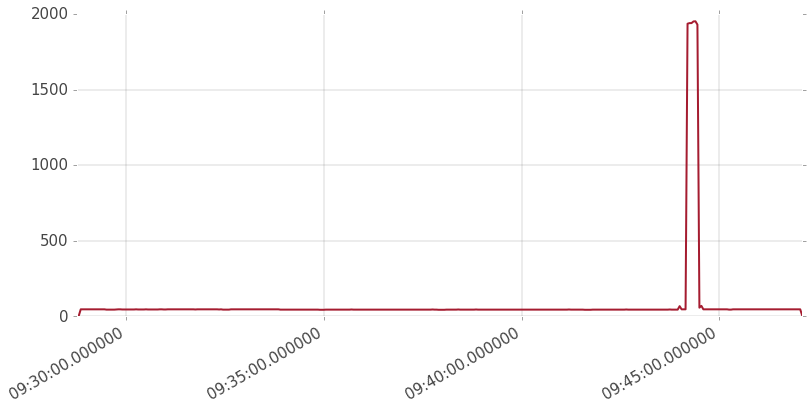

In [26]:
elec['microwave'].get_activations()[0].plot();

Obviously the microwave signature is a pic of short duration while the fridge cycle is a bit longer. In this study we try to retrieve from the aggregated data the times an appliance switches on, the times it swithes off and the average power comsuption in each cycle. We call this the rectangle method. Essentially, we want to retrieve from the aggregated data, this type of representation:

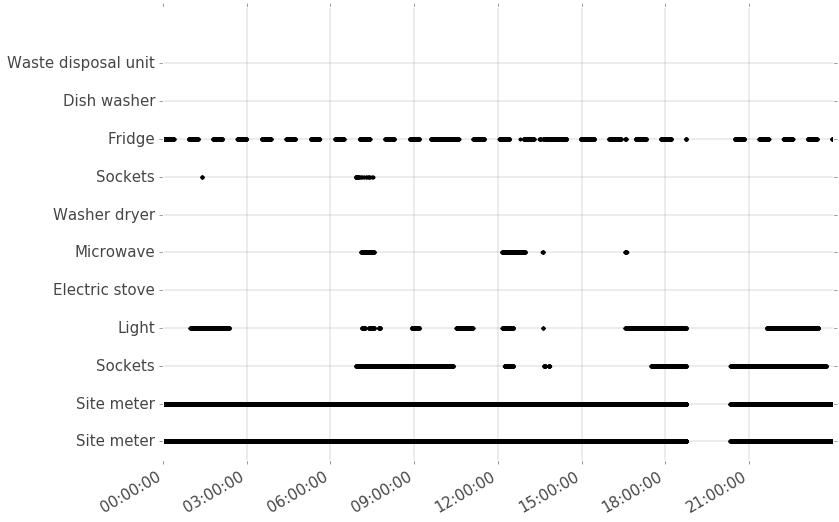

In [42]:
dataset.buildings[2].elec.plot_when_on()

# Data pipeline

## Selecting appliances

We train each neural network per appliance. This is different from the CO and FHMM methods.

## Selecting time sequences

We down sample the main meters and the submeters to 6 samples per seconds in order to have the aggregated and the submeter sequences properly aligned. We throw away any activation shorter than some threshold duration to avoid spurious spikes.

## Selecting houses

We choose to train the algorithm on house 1,2,3 and 6 and test the data on house 6.

## Dealing with unbalanced data: selecting aggregated data windows

We first exctract using NILMTK libraries the appliance (here the fridge) activations in the time series. We concatenate the times series from house 1,2,3, and 6 for the training set and will test on house 5. We feed to our neural network algorithm (detailed later) balanced mini-batches of data sequences of aggregated data in which the fridge is activated and sequences in which it is not activated. This is a way to deal with unbalanced data -- there are more sequences where the fridge is not activated than sequences with the fridge activated. Most of the data pipeline used is borrowed from https://github.com/JackKelly/neuralnilm. 

## Synthetic aggregated data

We use the method from Jack Kelly to create synthetic data. To create a single sequence of synthetic data, we start with two vectors of zeros: one vector will become the input to the net; the other will become the target. The length of each vector defines the ‘window width’ of data that the network sees. We go through five appliance classes and decide whether or not to add an activation of that class to the training sequence. There is a 50% chance that the target appliance will appear in the sequence and a 25% chance for each other ‘distractor’ appliance. For each selected appliance class, we randomly select an appliance activation and then randomly pick where to add that activation on the input vector. Distractor appliances can appear anywhere in the sequence (even if this means that only part of the activation will be included in the sequence). The target appliance activation must be completely contained within the sequence (unless it is too large to fit).

We ran neural networks with and without synthetic aggregated data. We found that synthetic data acts as a regulizer, it improves the scores on useen house.

All the codes that perform the operation described in this section 2 are in https://github.com/tperol/neuralnilm.

In [ ]:
# here are the code that perform the preprocessing of the mini batches
import nilmtk
from nilmtk.utils import print_dict
from nilmtk import DataSet
from neuralnilm.data.loadactivations import load_nilmtk_activations
from neuralnilm.data.syntheticaggregatesource import SyntheticAggregateSource
from neuralnilm.data.realaggregatesource import RealAggregateSource
from neuralnilm.data.stridesource import StrideSource
from neuralnilm.data.datapipeline import DataPipeline
from neuralnilm.data.processing import DivideBy, IndependentlyCenter

# ------------
# create dictionary with train, unseen_house, unseen_appliance
# ------------
def select_windows(train_buildings, unseen_buildings):
    windows = {fold: {} for fold in DATA_FOLD_NAMES}

    def copy_window(fold, i):
        windows[fold][i] = WINDOWS[fold][i]

    for i in train_buildings:
        copy_window('train', i)
        copy_window('unseen_activations_of_seen_appliances', i)
    for i in unseen_buildings:
        copy_window('unseen_appliances', i)
    return windows


def filter_activations(windows, activations):
    new_activations = {
        fold: {appliance: {} for appliance in APPLIANCES}
        for fold in DATA_FOLD_NAMES}
    for fold, appliances in activations.iteritems():
        for appliance, buildings in appliances.iteritems():
            required_building_ids = windows[fold].keys()
            required_building_names = [
                'UK-DALE_building_{}'.format(i) for i in required_building_ids]
            for building_name in required_building_names:
                try:
                    new_activations[fold][appliance][building_name] = (
                        activations[fold][appliance][building_name])
                except KeyError:
                    pass
    return activations    
NILMTK_FILENAME = './redd_data/redd.h5'
SAMPLE_PERIOD = 6
STRIDE = None
APPLIANCES = ['fridge']
WINDOWS = {
    'train': {
        1: ("2011-04-19", "2011-05-21"),
        2: ("2011-04-19", "2013-05-01"),
        3: ("2011-04-19", "2013-05-26"),
        6: ("2011-05-22", "2011-06-14"),
    },
    'unseen_activations_of_seen_appliances': {
        1: ("2011-04-19", None),
        2: ("2011-04-19", None),
        3: ("2011-04-19", None),
        6: ("2011-05-22", None),
    },
    'unseen_appliances': {
        5: ("2011-04-19", None)
    }
}

# get the dictionary of activations for each appliance
activations = load_nilmtk_activations(
    appliances=APPLIANCES,
    filename=NILMTK_FILENAME,
    sample_period=SAMPLE_PERIOD,
    windows=WINDOWS
)

# ------------
# get pipeline for the fridge example
# ------------
num_seq_per_batch = 16
target_appliance = 'fridge'
seq_length = 512
train_buildings = [1, 2, 3, 6]
unseen_buildings = [5]
DATA_FOLD_NAMES = (
    'train', 'unseen_appliances', 'unseen_activations_of_seen_appliances')

filtered_windows = select_windows(train_buildings, unseen_buildings)
filtered_activations = filter_activations(filtered_windows, activations)

synthetic_agg_source = SyntheticAggregateSource(
    activations=filtered_activations,
    target_appliance=target_appliance,
    seq_length=seq_length,
    sample_period=SAMPLE_PERIOD
)

real_agg_source = RealAggregateSource(
    activations=filtered_activations,
    target_appliance=target_appliance,
    seq_length=seq_length,
    filename=NILMTK_FILENAME,
    windows=filtered_windows,
    sample_period=SAMPLE_PERIOD
)
# ------------
# needed to rescale the input aggregated data
# rescaling is done using the a first batch of num_seq_per_batch sequences
sample = real_agg_source.get_batch(num_seq_per_batch=1024).next()
sample = sample.before_processing
input_std = sample.input.flatten().std()
target_std = sample.target.flatten().std()
# ------------



pipeline = DataPipeline(
    [synthetic_agg_source, real_agg_source],
    num_seq_per_batch=num_seq_per_batch,
    input_processing=[DivideBy(input_std), IndependentlyCenter()],
    target_processing=[DivideBy(target_std)]
)


# ------------
# create the validation set
# ------------

num_test_seq = 101

X_valid = np.empty((num_test_seq*num_seq_per_batch, seq_length))
Y_valid = np.empty((num_test_seq*num_seq_per_batch, 3))

for i in range(num_test_seq):
    (x_valid,y_valid) = pipeline.train_generator(fold = 'unseen_appliances', source_id = 1).next()
    X_valid[i*num_seq_per_batch: (i+1)*num_seq_per_batch,:] = x_valid[:,:,0]
    Y_valid[i*num_seq_per_batch:  (i+1)*num_seq_per_batch,:] = y_valid
X_valid = np.reshape(X_valid, [X_valid.shape[0],X_valid.shape[1],1])

# Standardisation of the input data (aggregated data)

A typical step in the data pipeline of neural network is the standardization of data. For each sequences of 512 samples (= 85 seconds) we substract the mean to center the sequence. Furthermore every input sequence is divided by the standard deviation of a random sample in the training set. In this case we cannot divide each sequence by its own standard deviation because it would delete information about the scale of the signal.

This is done via:

In [ ]:
# needed to rescale the input aggregated data
# rescaling is done using the a first batch of num_seq_per_batch sequences
sample = real_agg_source.get_batch(num_seq_per_batch=1024).next()
sample = sample.before_processing
input_std = sample.input.flatten().std()
target_std = sample.target.flatten().std()
# ------------

# Output data (start time, end time and average power)

The output of the neural network is 3 neurons: start time, end time and average power. We rescale the time to the interval [0,1]. Therefore if the fridge starts in the middle of the input sequences the output of the first neuron is 0.5. If its stops after the end of the input window the ouput of the second neuron is set to 1. The third neuron is the average power during the activation period. Of course this is set to 0 when it is not activated during the input sequence. We also post process the data by setting any start time lower than 0 to 0 and end time higher than 1 to 1. We create a average power threshold set to 0.1 that indicates if the appliance was active or not (under the threshold the appliance is considered off, above it is considered on).

Here we show as an example the input data and the ouput calculated by a trained network. We compare this with the real appliance activation. <img src='./figures/output_example.png'>

As we can see here the network does a very good job at detecting the activation of the fridge. The red line is the aggregated data. In the flat region it would be impossible to detect the activation of the fridge with human eye. We would tend to put an activation in the step region. However the network does a very accurate prediction of the activation of the fridge !

# Scores - performance evaluation of the neural network

Because of the dimension of the ouput we choose classification score metrics. When the starting time and the ending time are both 0 we call this a negative. We also call negative if the power average is lower than threshold. Otherwise this is positive (the appliance is activated). We call TP true positive, TN true negative, FP false positive and FN false negative. The various metrics/scores used in this study are

$$ recall = \frac{TP}{TP + FN} $$

$$ precision = \frac{TP}{TP + FP} $$

$$ F1 = 2 * \frac{precision* recall}{precision + recall} $$

$$ accuracy = \frac{TP + TN}{P + N} $$

where P is the number of positives and N the number of negatives.

The code to compute can be found in neuralnilm/scores and reproduced partially here.

In [43]:
def scores(Y_pred, Y_test, activation_threshold = 0.1 ,plot_results= True,  print_results = False):

    """
    a function that computes the classification scores with various metrics
    return: dictionary with the various scores

    """

    # post process the data

    np.putmask(Y_pred[:,0], Y_pred[:,0] <=0, 0)
    np.putmask(Y_pred[:,1], Y_pred[:,1] >=1, 1)
    np.putmask(Y_pred[:,0],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,1] < Y_pred[:,0],0)
    np.putmask(Y_pred[:,1],Y_pred[:,2] < activation_threshold,0)
    np.putmask(Y_pred[:,0],Y_pred[:,2] < activation_threshold,0)    

    # find negative in prediction
    pred_negatives = (Y_pred[:,0] ==0) &(Y_pred[:,1] ==0)
    pred_positives = ~pred_negatives
    obs_negatives = (Y_test[:,0] ==0) &(Y_test[:,1] ==0)
    obs_positives = ~obs_negatives
    TP = obs_positives[pred_positives].sum()
    FN = obs_positives[pred_negatives].sum()
    TN = obs_negatives[pred_negatives].sum()
    FP = obs_negatives[pred_positives].sum()

    recall = TP / float(TP + FN)
    precision = TP / float(TP+ FP)
    f1 = 2* precision*recall / (precision + recall)
    accuracy = (TP + TN)/ float(obs_negatives.sum() +obs_positives.sum() )
    if print_results:
        print('number of Predicted negatives:',pred_negatives.sum() )
        print('number of Predicted positives:',pred_positives.sum() )
        print('number of Observed negatives:', obs_negatives.sum() )
        print('number of Observed positives:', obs_positives.sum() )
        print('f1:',  f1)
        print('precision :' ,precision)
        print('recall : ', recall)
        print('accuracy:', accuracy)

    results = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall_score': recall}
    if plot_results:
        pd_results = pd.DataFrame.from_dict(results, orient = 'index')
        pd_results = pd_results.transpose()    
        sns.barplot(data = pd_results)

    return results

# Implementation strategy for real time data augmentation

While the neural network runs an **NVIDIA GeForce GT 750M (GPU)** we maintain the **CPU** busy doing the data augmentation in real time (load aggregated data, create the synthetic data, preprocess the mini-batch to be fed to the neural network). For this we create a **python generator** that creates a queue of 50 mini-batch and feed them successively to the GPU for training.

The pipeline class can be found in neuralnilm.data.datapiline at https://github.com/tperol/neuralnilm and is partially reproduced here. We do the same to generate the validation and test set.

In [ ]:
    def train_generator(self, fold='train', enable_all_appliances=False,
                  source_id=None, reset_iterator=False,
                  validation=False ):
        """
        class method that yield generator for training the neural network
        parameters:
        ----------
            fold: 'train' for training or 'unseen_appliance' for testing/validation
            source_id: if None we use both real and synthetic data with 50:50 ratio            
                       if 1 , only use the real data
                       if 0, only use the synthetic data

        output:
        ---------
            generator (X_train,Y_train): a tuple with X_train being the mini-batch for training
                                        and Y_train being the mini-batch of labels
        """
        while 1:
            batch_iter = self.get_batch(fold, enable_all_appliances, source_id, reset_iterator,validation)
            X_train = batch_iter.input
            input_dim = X_train.shape[1]
            Y_train = self._get_output_neurons(batch_iter)
            yield (np.reshape(X_train, [self.num_seq_per_batch, input_dim, 1]), Y_train.astype(np.float32))
            
    def _get_output_neurons(self, new_batch):

        """
        
        class method that generates the indices needed for the generator
        Once the network has seen all the sample, the algorithm feed again the mini-batch
        by reinitialization of the generator (there is no StopIteration error raised)
        
        Suffling of the mini-batch is the default strategy implemented

        """
        batch_size = new_batch.target.shape[0]
        neural_net_output = np.empty((batch_size, 3))
        
        for b in range(batch_size):
            seq =  new_batch.target[b]

            # case 1 and 2: if the signal start at 0
            if seq[0] > 0:
                start = 0
                stop_array = np.where(seq > 0)[0]
                # case 2: signal stops after 1
                # set stop to the last element
                if len(stop_array) == 0:
                    stop = seq[-1]
                # case 1: signal stops before 1
                else:
                    stop = stop_array[-1]  
                # calculate avg power
                avg_power =  np.mean(seq[start:stop + 1])

            # case 3: signal starts after 0 and before 1
            else:
                start_array = np.where(seq > 0)[0]
                if len(start_array) == 0:
                    # case 5: there is no signal in the window
                    start = 0
                    stop = 0
                    avg_power = 0
                else:
                    start = start_array[0]
                    # find stop
                    stop_array = np.where(seq > 0)[0]
                    # case 4: signal stops after 1
                    # set to the last element
                    if len(stop_array) == 0:
                        stop = seq[-1]
                    else:
                        stop = stop_array[-1]        
                    avg_power =  np.mean(seq[start:stop + 1])
                    
            start = start / float(new_batch.target.shape[1] - 1)
            stop = stop  / float(new_batch.target.shape[1] - 1)
            if stop < start:
                raise ValueError("start must be before stop in sequence {}".format(b))

            neural_net_output[b, :] = np.array([start, stop, avg_power])

        return neural_net_output                 

# Network architecture

We use a convolutional neural network (ConvNet) to take advantage of the translation invariance. We want the ConvNet to recognize target appliance activation anywhere in the sequence. For this project we have tried multiple architecture that are reported later on. These architecture all have a first convolutional layer of filter size 3 and stride 1. We have played with both the filter size and the number of output filters on the first layer. We have found that 16 filters is a reasonable number -- increasing the number of filters in the first layer did not improve significantly the scores.

The best neural network we found consist of 

* Input layer: one channel and lenght of 512 samples
* 1D convolutional layer (filter size = 3, stride = 1 , number of filters = 16, activation function = relu, border mode = valid, weight initialization = normal distribution)
* Fully connected layer (N = 1024, activation function = relu, weight initialization = normal distribution)
* Fully connected layer (N = 512, activation function = relu, weight initialization = normal distribution)
* Fully connected layer (N= 3, activation function = relu)

The ouput has 3 neurons activated by a relu activation function since the output cannot be negative. We have tried other networks that are reported later in this notebook. However this is the layout of the best one we found.

# Loss function and optimizer

## Loss function

Since the output neurons spans the real axis there is no other choice than using a L2 norm for the loss function. This is (predicted start time - true start time)$^2$ + (predicted end time - true end time)$^2$ + (predicted average power - true average power)$^2$. The total loss function is the sum of the loss function for all the sample in a mini-batch.

## Optimizer

We have tried various optimizer to find the best one. We used a classical **Stochastic Gradient Descent** to update the weights where we feed one mini-batch chosen randomly to the neural network and then update each weight

$$w_j = w_j - \eta \frac{\partial L}{\partial w_j} $$

where $L$ is the loss function evaluated for the given mini-batch. The gradient of the loss function is calculated using the backpropagation algorithm (not detailed here for simplicity). At each epoch we decrease the learning rate $eta$ to allow the algorithm to converge towards a local minimum.

We tried a variaton of SGD by using the **momentum method **. This method has some physical interpretation where $\mu$ is the friction coefficient. In this case the weights are update using 

$$w_j = w_j + \mu v - \eta \frac{\partial L}{\partial w_j} $$

where $v$ is the velocity. An other tested implementation is the **Nesterov momentum** in which, at a given position in the landscape of weight we look one step ahead with the momentum and then evaluate the gradient there to calculate the new value of the weight. A pseudo code for this would be 

In [ ]:
w_ahead = w + mu * v
# evaluate dw_ahead 
v = mu * v - learning_rate * dw_ahead
x += v

We found by experimenting that the best optimizer is **Adam** (http://arxiv.org/pdf/1412.6980v8.pdf). A pseudo code for Adam is

In [ ]:
m = beta1*m + (1-beta1)*dw
v = beta2*v + (1-beta2)*(dw**2)
w += - learning_rate * m / (np.sqrt(v) + eps)

where *dw* is the gradient of the lost function with respect to the considered weight and *w* the considered weight. The hyperparameter for this optimizer are beta1, beta2 and eps. We set beta_1=0.9, beta_2=0.999, epsilon=1e-08 and the learning rate = 1e-3.

# Experimenting with ConvNet architectures

For the implementation of the ConvNet we use Keras (http://keras.io). This is a library implemented on top of Theano and Tensorflow (in this case we use Theano to take advantage of the GPU, GPU training is not yet available on Mac OS using TensorFlow). Here we show the code ran using GPU and Keras to train our best ConvNet.

In [ ]:
# import Keras related libraries
from keras.layers import Input, Dense, Flatten, MaxPooling1D, AveragePooling1D, Convolution1D
from keras.models import Model
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import time
from keras.models import model_from_json
import pickle

# ------------
exp_number = 13
output_architecture = './tmpdata/convnet_architecture_exp' + str(exp_number) + '.json'
best_weights_during_run = './tmpdata/weights_exp' + str(exp_number) + '.h5'
final_weights = './tmpdata/weights_exp' + str(exp_number) + '_final.h5'
loss_history = './tmpdata/history_exp' + str(exp_number) + '.pickle'
# ------------


# ------------
# a class used to record the training and validation loss 
# at the end of each epoch

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.train_losses = [] 
        self.valid_losses = []

    def on_epoch_end(self, epoch, logs = {}):
        self.train_losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        
# ------------        



# input sequence
input_seq = Input(shape = (seq_length, 1))
# first convolutional layer
conv1_layer =  Convolution1D(nb_filter = 16, filter_length = 3, border_mode='valid',
                      init = 'normal', activation =  'relu')
conv1 = conv1_layer(input_seq)
# flatten the weights
flat = Flatten()(conv1)
# first dense layer
dense1 = Dense(1024, activation = 'relu')(flat)
# second dense layer
dense2 = Dense(512, activation = 'relu', init= 'normal')(dense1)
# output layer
predictions = Dense(3, activation = 'linear')(dense2)   
# create the model
model = Model(input=input_seq, output=predictions)
# compile the model -- define the loss and the optimizer
model.compile(loss='mean_squared_error', optimizer='Adam')
# record the loss history
history = LossHistory()
# save the weigths when the vlaidation lost decreases only
checkpointer = ModelCheckpoint(filepath=best_weights_during_run, save_best_only=True, verbose =1 )
# fit the network using the generator of mini-batches.
model.fit_generator(pipeline.train_generator(fold = 'train'), \
                    samples_per_epoch = 30000, \
                    nb_epoch = 20, verbose = 1, callbacks=[history, checkpointer],
                   validation_data = (x_valid,y_valid), max_q_size = 50)
losses_dic = {'train_loss': history.train_losses, 'valid_loss':history.valid_losses}
# save history
losses_dic = {'train_loss': history.train_losses, 'valid_loss':history.valid_losses}
with open(loss_history, 'wb') as handle:
  pickle.dump(losses_dic, handle)

print('\n saving the architecture of the model \n')
json_string = model.to_json()
open(output_architecture, 'w').write(json_string)

print('\n saving the final weights ... \n')
model.save_weights(final_weights, overwrite = True)
print('done saving the weights')

print('\n saving the training and validation losses')

print('This was the model trained')
print(model.summary())

## One convolutional layer

Here we present the results from the ConvNet detailed in the previous cell. We first load the ConvNet architecture, the weights and the history of the training and validation losses (the network has been trained previously using GPU).

In [63]:
from keras.models import model_from_json
# load experiments number 
exp_number = 13
# load the model architecture
output_architecture = './tmpdata/convnet_architecture_exp' + str(exp_number) + '.json'
# load the weights for the lowest validation loss during training
best_weights_during_run = './tmpdata/weights_exp' + str(exp_number) + '.h5'
# load the final weights at the end of the 20 epochs
final_weights = './tmpdata/weights_exp' + str(exp_number) + '_final.h5'
model = model_from_json(open(output_architecture).read())
# load intermediate or final weights
model.load_weights(best_weights_during_run)
model.compile(loss='mean_squared_error', optimizer='sgd')
# print the summary of the architecture
model.summary()
# load the loss summary (training and validation losses)
import pickle
losses = pickle.load( open('./tmpdata/history_exp' + str(exp_number) + '.pickle'   , 'rb'))
# load the test set
test_set = pickle.load( open('./tmpdata/TestSet.pickle', 'rb'))
X_test = test_set['X_test']
Y_test = test_set["Y_test"]

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 512, 1)      0                                            
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 510, 16)     64          input_1[0][0]                    
____________________________________________________________________________________________________
flatten_1 (Flatten)                (None, 8160)        0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                    (None, 1024)        8356864     flatten_1[0][0]                  
___________________________________________________________________________________________

{'accuracy': 0.70776608910891092,
 'f1_score': 0.77578635014836794,
 'precision': 0.63542679370017496,
 'recall_score': 0.99573430834856791}

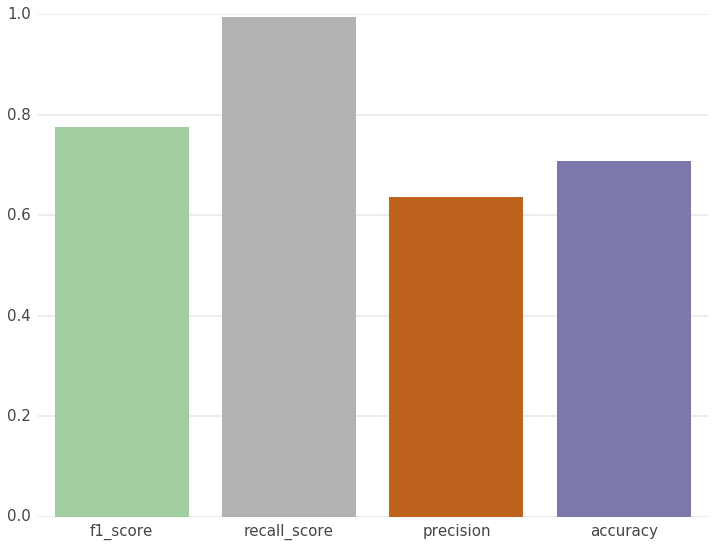

In [68]:
# Here we predict the output from the neural network and show the scores
import neuralnilm.scores
Y_pred = model.predict(X_test)
scores(Y_pred, Y_test)

This is a very good F1 score, much better than with any other method tested before. Here we show the evolution of the training loss and the validation loss.

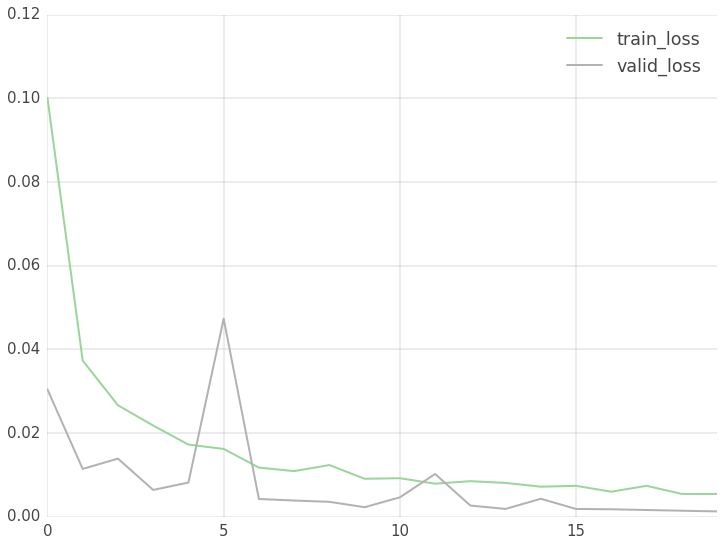

In [70]:
from neuralnilm.scores import plot_loss
plot_loss(losses)

The training and validation loss during training decreases simulateanously. There is no overfitting. We stop the simulation after 20 epochs but the model was still improving. 20 epochs on GPU took about 1.5 hours.

# Two convolutional layers

Since we are not overfitting we did not add any Pooling layer or Dropout to the previous network. However we experimented an other network with an additional convolutional layer and train the model over 30 epoch. The model is the following:

In [71]:
exp_number = 14
output_architecture = './tmpdata/convnet_architecture_exp' + str(exp_number) + '.json'
best_weights_during_run = './tmpdata/weights_exp' + str(exp_number) + '.h5'
final_weights = './tmpdata/weights_exp' + str(exp_number) + '_final.h5'
model = model_from_json(open(output_architecture).read())
# load intermediate or final weights
model.load_weights(best_weights_during_run)
model.compile(loss='mean_squared_error', optimizer='sgd')
model.summary()
# load the loss summary
import pickle
losses = pickle.load( open('./tmpdata/history_exp' + str(exp_number) + '.pickle'   , 'rb'))
# load the test set
test_set = pickle.load( open('./tmpdata/TestSet.pickle', 'rb'))
X_test = test_set['X_test']
Y_test = test_set["Y_test"]

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 512, 1)      0                                            
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 510, 16)     64          input_1[0][0]                    
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)    (None, 508, 16)     784         convolution1d_1[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)                (None, 8128)        0           convolution1d_2[0][0]            
___________________________________________________________________________________________

There are 2 convolutional layers with 16 filters and 2 dense layers and the output layer. In this case the results are fairly similar to the network presented above.

{'accuracy': 0.703125,
 'f1_score': 0.77292628091350135,
 'precision': 0.6318436834977752,
 'recall_score': 0.99512492382693485}

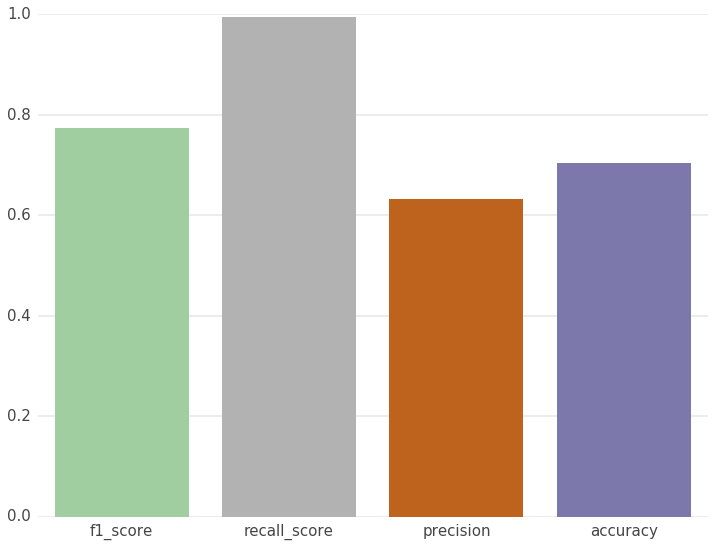

In [72]:
import neuralnilm.scores
Y_pred = model.predict(X_test)
scores(Y_pred, Y_test)

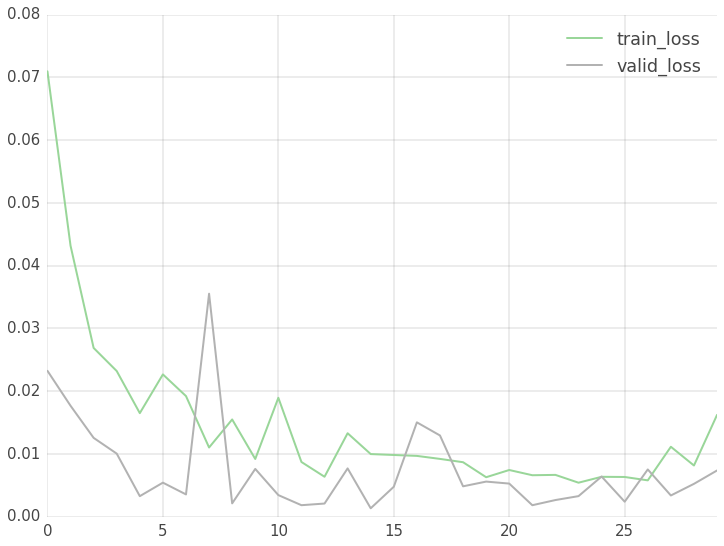

In [73]:
from neuralnilm.scores import plot_loss
plot_loss(losses)

## Results for the microwave

Here we run the ConvNet with one layer on the microwave. We train using house 1 and 2 and test on house 5.

In [7]:
from keras.models import model_from_json
exp_number = 13
output_architecture = './tmpdata/convnet_architecture_exp' + str(exp_number) + '.json'
best_weights_during_run = './tmpdata/weights_exp' + str(exp_number) + '.h5'
final_weights = './tmpdata/weights_exp' + str(exp_number) + '_final.h5'
model = model_from_json(open(output_architecture).read())
# load intermediate or final weights
model.load_weights(best_weights_during_run)
model.compile(loss='mean_squared_error', optimizer='sgd')
model.summary()
# load the loss summary
import pickle
losses = pickle.load( open('./tmpdata/history_exp' + str(exp_number) + '.pickle'   , 'rb'))
# load the test set
test_set = pickle.load( open('./tmpdata/TestSet_microwave.pickle', 'rb'))
X_test_microwave = test_set['X_test']
Y_test_microwave = test_set["Y_test"]

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 512, 1)      0                                            
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 510, 16)     64          input_1[0][0]                    
____________________________________________________________________________________________________
flatten_1 (Flatten)                (None, 8160)        0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                    (None, 1024)        8356864     flatten_1[0][0]                  
___________________________________________________________________________________________

In [8]:
from neuralnilm.scores import scores
Y_pred_microwave = model.predict(X_test_microwave)
scores(Y_pred_microwave, Y_test_microwave)

{'accuracy': 0.50773514851485146,
 'f1_score': 0.67297019527235347,
 'precision': 0.50712515489467158,
 'recall_score': 1.0}